# MLE CLTV analysis for mixed Geometric distributions

In [1]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.geom import Geometric, neg_loglikelihood
from jax_cltv.plots.plot_data import plot_churns, plot_survives

plt.style.use('bmh')

/Users/yukoga/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [3]:
theta_true_1 = 0.7
theta_true_2 = 0.1

ds1, data1 = DummySubscriptions(p=theta_true_1, size=800)()
ds2, data2 = DummySubscriptions(p=theta_true_2, size=200)()

In [4]:
df1 = ds1.to_pandas()
df1['segment'] = 'A'
df2 = ds2.to_pandas()
df2['segment'] = 'B'

df = pd.concat([df2, df1], ignore_index=True)
df = df.fillna(0)

In [5]:
df

,Day0,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,...,Day39,Day40,Day41,Day42,Day43,Day44,Day45,Day46,Day47,segment
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,B
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
3,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,B
4,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A
996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A
997,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,A


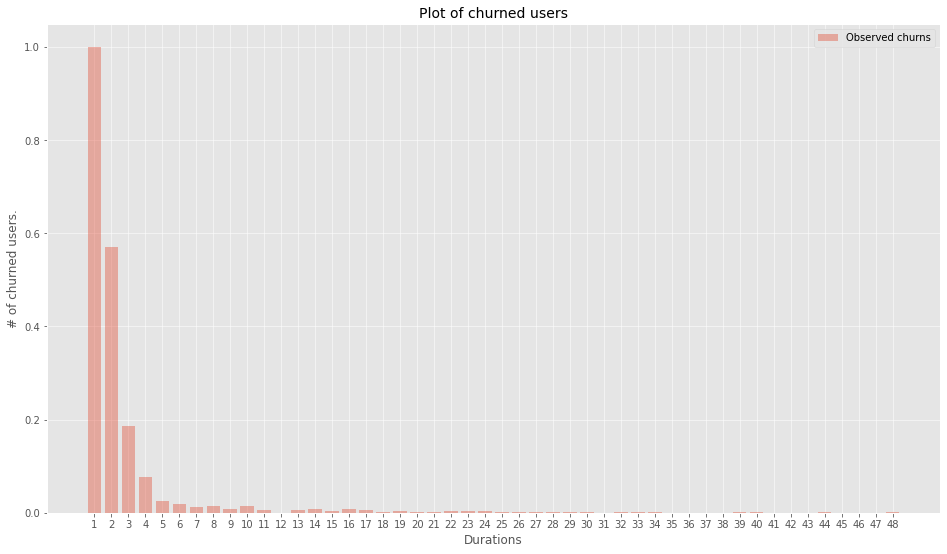

In [6]:
ax = plot_churns(df.iloc[:, :-1], kind='bar', yscale='linear', density=True)
plt.show()


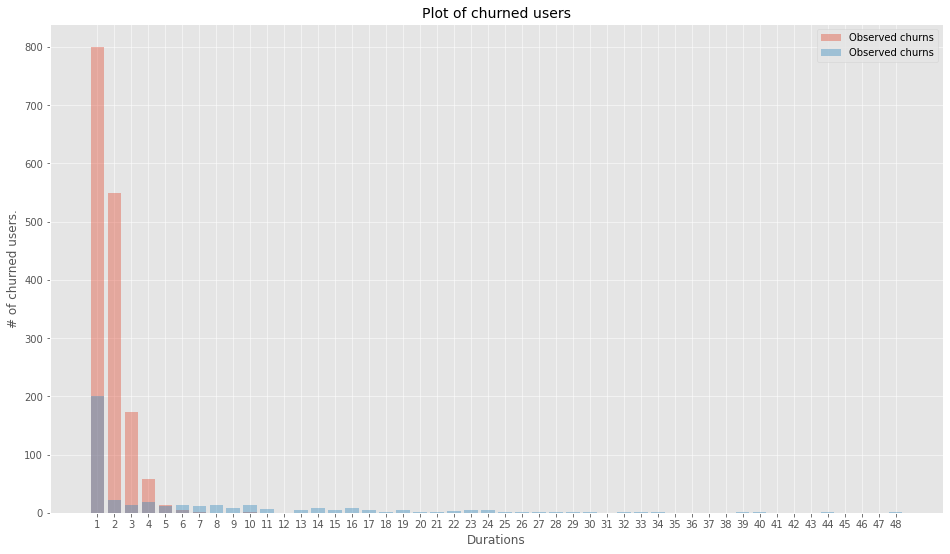

In [7]:
ax = plot_churns(df[df['segment']=='A'].iloc[:, :-1], yscale='linear', kind='bar', density=False)
ax = plot_churns(df[df['segment']=='B'].iloc[:, :-1], yscale='linear', kind='bar', density=False, ax=ax)
plt.show()


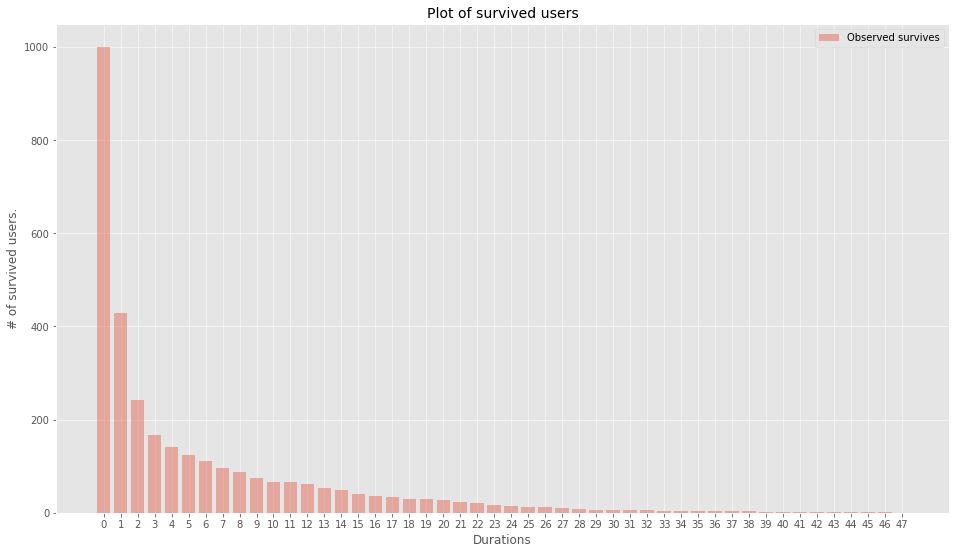

In [8]:
ax = plot_survives(df.iloc[:, :-1], density=False)
plt.show()

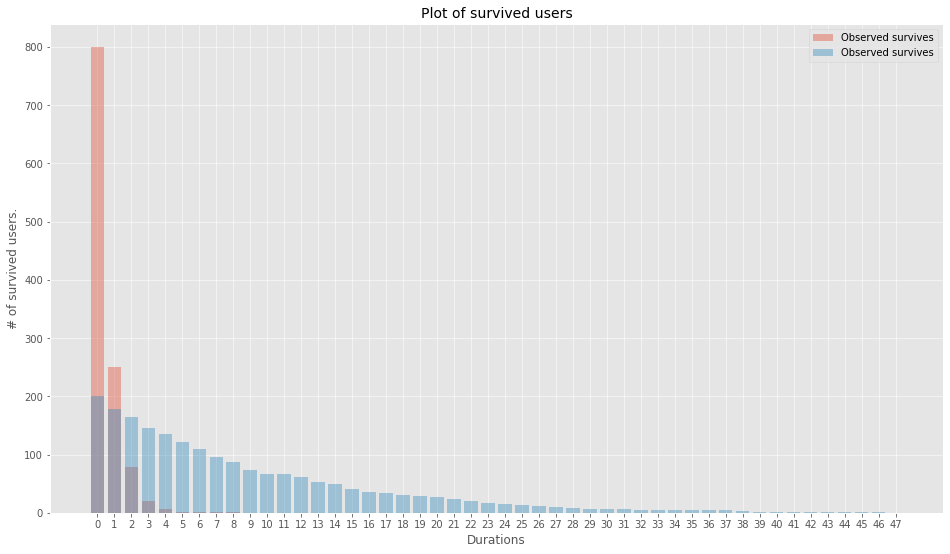

In [9]:
ax = plot_survives(df[df['segment']=='A'].iloc[:, :-1], yscale='linear', density=False)
ax = plot_survives(df[df['segment']=='B'].iloc[:, :-1], yscale='linear', density=False, ax=ax)
plt.show()

## Inference with MLE

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
df_train, df_test = train_test_split(df.iloc[:, :-1], test_size=0.3, random_state=1)

In [12]:
y_train = df_train.sum(axis=1).astype('int')
y_test = df_test.sum(axis=1).astype('int')

In [13]:
print(f'Training data: {y_train.shape}')
print(f'Test data: {y_test.shape}')

Training data: (700,)
Test data: (300,)


In [14]:
df.loc[y_train.index, 'segment'].value_counts() / y_train.shape[0]

A    0.802857
B    0.197143
Name: segment, dtype: float64

In [15]:
df.loc[y_test.index, 'segment'].value_counts() / y_test.shape[0]

A    0.793333
B    0.206667
Name: segment, dtype: float64

In [16]:
def model():
    return MLE(dist=Geometric(0.8))

def loss(w, x, y):
    nl, _ = neg_loglikelihood(x, w[0])
    return nl

In [17]:
init_variables(['m', 'res'])

m = model()
w_init = jnp.array(list(m.params.values()))
res = m.fit(loss, w_init, (jnp.array(y_train), None))

In [18]:
res.params

DeviceArray([0.32619017], dtype=float32)

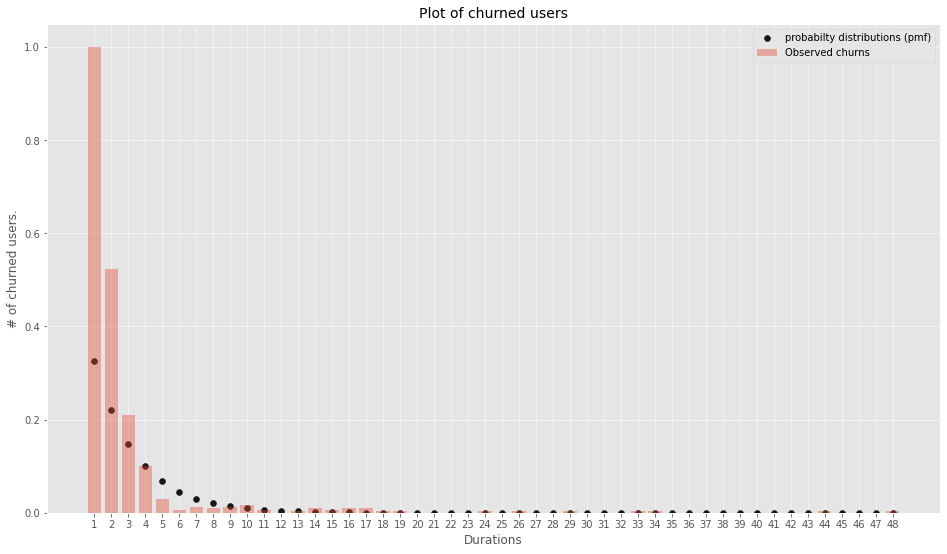

In [19]:
ax = plot_churns(df_test, theta=res.params, kind='bar', density=True)
plt.show()

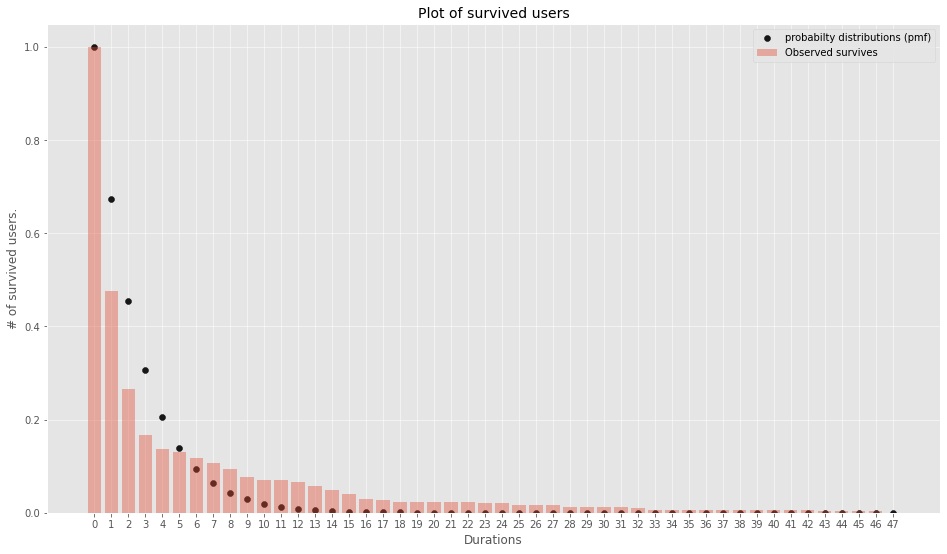

In [20]:
ax = plot_survives(df_test, theta=res.params, density=True)
plt.show()

In [21]:
df_test_plot = df.loc[df_test.index, :]

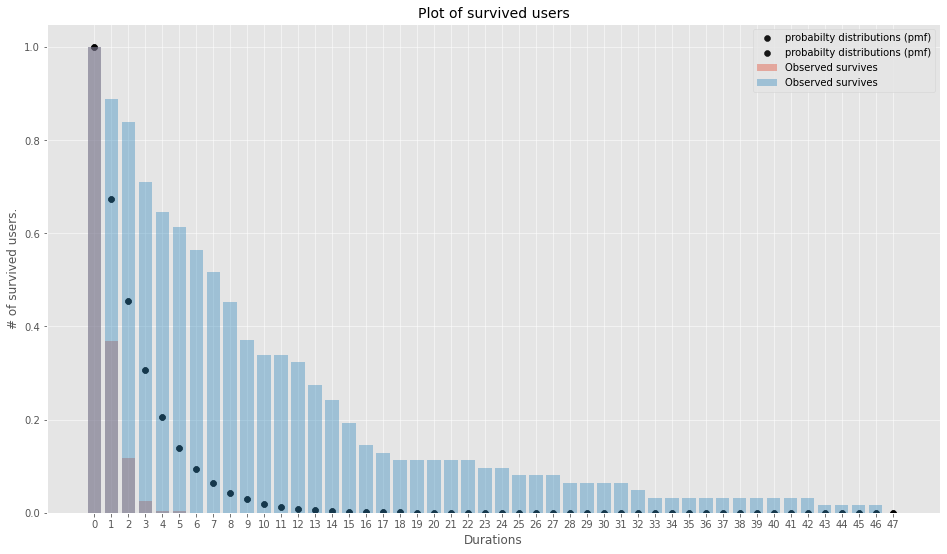

In [22]:
ax = plot_survives(df_test_plot[df_test_plot['segment']=='A'].iloc[:, :-1], yscale='linear', theta=res.params, density=True)
ax = plot_survives(df_test_plot[df_test_plot['segment']=='B'].iloc[:, :-1], yscale='linear', theta=res.params, density=True, ax=ax)
plt.show()

In [23]:
from jax.scipy.stats import geom

In [24]:
M = 100
d = 0.15

In [25]:
def calc_revenues(row, df, key, m, d):
    idx = df[df[key]==row].index[0]
    return  (m/(1 + d)**idx) * row


def calc_cltv(theta, d, m, T):
    N, D = df.shape
    dcf = []
    s = []

    def churn(theta, t):
        return (1-theta)**(t-1) * theta

    def survive(theta, t):
        return (1-theta)**t

    for t in range(T+1):
        s.append(survive(theta, t))
        dcf.append((1/(1+d)**t))

    clv = m * np.sum([x * y for x, y in zip(s, dcf)])
    return clv

In [26]:
def get_df_cltv(df, m, d, theta):
    N, D = df.shape
    df_cltv = pd.concat([
        pd.DataFrame({'observed_churns': df.sum(axis=1).value_counts()}),
        pd.DataFrame({'pmf_churn_rate': geom.pmf(jnp.array(range(D)), theta)})
    ], axis=1)
    df_cltv.fillna(0, inplace=True)
    df_cltv['observed_survives'] = N - df_cltv['observed_churns'].cumsum()
    df_cltv['ob_churn_rate'] = df_cltv['observed_churns'] / N
    df_cltv['ob_survive_rate'] = df_cltv['observed_survives'] / N
    df_cltv['pmf_survive_rate'] = 1 - df_cltv['pmf_churn_rate'].cumsum()
    df_cltv['day'] = df_cltv.index.map(lambda x: f'Day{int(x)}')
    df_cltv['ob_monetization'] = df_cltv['ob_survive_rate'].map(
        lambda x: calc_revenues(x, df_cltv, 'ob_survive_rate', m, d))
    df_cltv['ob_cltv'] = df_cltv['ob_monetization'].cumsum()

    return df_cltv

In [27]:
df_cltv = get_df_cltv(df_test, M, d, res.params)
df_cltv['modeled_cltv'] = df_cltv.index.map(
    lambda r: calc_cltv(res.params, d, M, int(r)))

In [28]:
df_cltv

,observed_churns,pmf_churn_rate,observed_survives,ob_churn_rate,ob_survive_rate,pmf_survive_rate,day,ob_monetization,ob_cltv,modeled_cltv
0.0,0.0,0.000000e+00,300.0,0.000000,1.000000,1.000000e+00,Day0,100.000000,100.000000,100.000000
1.0,157.0,3.261902e-01,143.0,0.523333,0.476667,6.738098e-01,Day1,41.449275,141.449275,158.592153
2.0,63.0,2.197902e-01,80.0,0.210000,0.266667,4.540197e-01,Day2,20.163831,161.613106,192.922568
3.0,30.0,1.480968e-01,50.0,0.100000,0.166667,3.059229e-01,Day3,10.958604,172.571710,213.037491
4.0,9.0,9.978905e-02,41.0,0.030000,0.136667,2.061338e-01,Day4,7.813961,180.385671,224.823260
5.0,2.0,6.723884e-02,39.0,0.006667,0.130000,1.388950e-01,Day5,6.463298,186.848969,231.728792
6.0,4.0,4.530620e-02,35.0,0.013333,0.116667,9.358877e-02,Day6,5.043822,191.892791,235.774899
7.0,3.0,3.052775e-02,32.0,0.010000,0.106667,6.306100e-02,Day7,4.009995,195.902786,238.145614
8.0,4.0,2.056990e-02,28.0,0.013333,0.093333,4.249108e-02,Day8,3.051083,198.953869,239.534664
9.0,5.0,1.386020e-02,23.0,0.016667,0.076667,2.863085e-02,Day9,2.179345,201.133214,240.348530


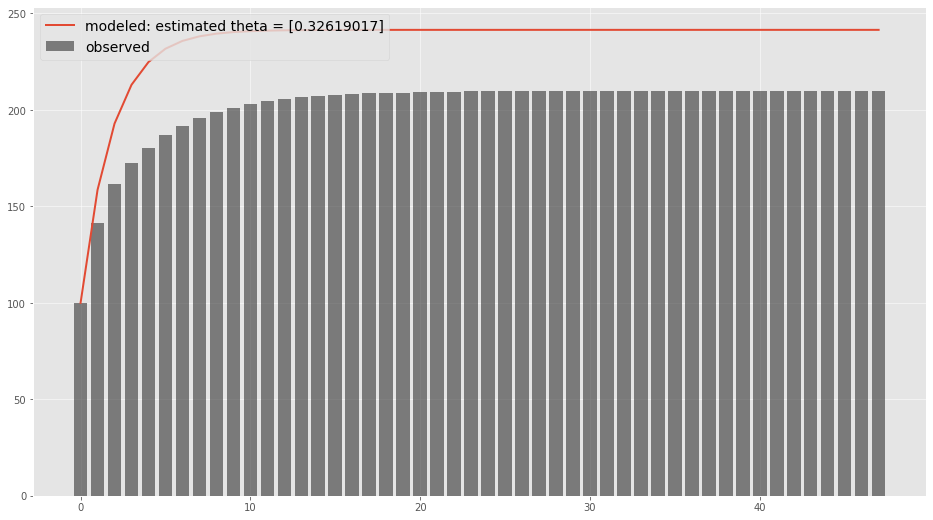

In [29]:
fig = plt.figure(figsize=(16, 9))
plt.bar(df_cltv.index, df_cltv['ob_cltv'], label='observed', color='#333333', alpha=.6)
plt.plot(df_cltv.index, df_cltv['modeled_cltv'], label=f'modeled: estimated theta = {res.params}')
plt.legend(fontsize=14)
plt.show()

In [30]:
print(f'Average retention days based on the true parameter: {1/theta_true_1}')
print(f'Average retention days based on the true parameter: {1/theta_true_2}')
print(f'Average retention days based on the training data: {df_train.sum(axis=1).mean()}')
print(f'Average retention days based on the test data: {df_test.sum(axis=1).mean()}')
print(f'Average retention days based on an inferenced parameter: {1/res.params.to_py()}')

Average retention days based on the true parameter: 1.4285714285714286
Average retention days based on the true parameter: 10.0
Average retention days based on the training data: 3.065714285714286
Average retention days based on the test data: 3.33
Average retention days based on an inferenced parameter: [3.0656962]


In [31]:
10.0 * 0.2 + 1.4285714285714286*0.8

3.1428571428571432